In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# !pip3 install scikit-learn
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from effCTR.models.Naive_Bayes import Naive_Bayes
from effCTR.models.Logistic_SGD import Logistic_SGD
from effCTR.utils.loss_functions import log_loss
from sklearn.linear_model import SGDClassifier
import time

Data used in this notebook can be found [here](https://www.kaggle.com/competitions/avazu-ctr-prediction/data). \
This notebook transforms the data into appropriate formats and shows how to use the algorithms developed in ``effCTR``.

# Read and Transform the data

In [2]:
df = pd.read_csv('train.gz')
df.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1.000009e+18,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,2,15706,320,50,1722,0,35,-1,79
1,1.000017e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
2,1.000037e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
3,1.000064e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15706,320,50,1722,0,35,100084,79
4,1.000068e+19,0,14102100,1005,1,fe8cc448,9166c161,0569f928,ecad2386,7801e8d9,...,1,0,18993,320,50,2161,0,35,-1,157


In [3]:
df.nunique()

id                  40428967
click                      2
hour                     240
C1                         7
banner_pos                 7
site_id                 4737
site_domain             7745
site_category             26
app_id                  8552
app_domain               559
app_category              36
device_id            2686408
device_ip            6729486
device_model            8251
device_type                5
device_conn_type           4
C14                     2626
C15                        8
C16                        9
C17                      435
C18                        4
C19                       68
C20                      172
C21                       60
dtype: int64

Dropping variables with lots of categories to prevent high dimensionality:

In [4]:
df = df[['click', 'C1', 'banner_pos', 'site_category',
         'app_category', 'device_type', 'device_conn_type',
         'C15', 'C16', 'C18']]

In [5]:
df.head()

,click,C1,banner_pos,site_category,app_category,device_type,device_conn_type,C15,C16,C18
0,0,1005,0,28905ebd,07d7df22,1,2,320,50,0
1,0,1005,0,28905ebd,07d7df22,1,0,320,50,0
2,0,1005,0,28905ebd,07d7df22,1,0,320,50,0
3,0,1005,0,28905ebd,07d7df22,1,0,320,50,0
4,0,1005,1,0569f928,07d7df22,1,0,320,50,0


Using one-hot encoding to transform dataframe into sparse matrix:

In [6]:
encoder = OneHotEncoder(drop='first', sparse_output=True)
df_sparse = encoder.fit_transform(df)
feature_names = encoder.get_feature_names_out(df.columns)

Splitting data into train and test set:

In [7]:
def get_train_test(df_sparse):
    y = df_sparse[:,0]
    X = df_sparse[:,1:]
    
    X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test(df_sparse)

# Apply Naive Bayes

To see the list of possible parameters used in the algorithm, check [here](https://github.com/kapa112/effCTR/blob/main/effCTR/models/Naive_Bayes.py#L11) \
Intialize and fit:

In [8]:
Naive_Bayes = Naive_Bayes()
Naive_Bayes.fit(X_train, y_train)

Obtain predictions and average log loss:

In [9]:
preds_bayes = Naive_Bayes.predict(X_test)
preds_bayes

array([0.05788977, 0.180956  , 0.31128074, ..., 0.03081143, 0.2926836 ,
       0.06849483])

In [10]:
log_loss_bayes = log_loss(preds_bayes, y_test)
log_loss_bayes

0.46318140239261707

# Apply Logistic SGD

To see the list of possible parameters used in the algorithm, check [here](https://github.com/kapa112/effCTR/blob/main/effCTR/models/Logistic_SGD.py#L20). \
Since ``Logistic_SGD`` has the same structure, we use equivalent methods as for Naive Bayes:

In [11]:
start_time = time.time()
LSGD = Logistic_SGD(chunksize=3200, max_epochs=1, learning_rate=0.0001)
LSGD.fit(X_train, y_train)
train_time = time.time() - start_time

# log_loss on train set
preds_logistic_train = LSGD.predict(X_train)
log_loss_logistic_train = log_loss(preds_logistic_train, y_train)

# log_loss on train set
preds_logistic_test = LSGD.predict(X_test)
log_loss_logistic_test = log_loss(preds_logistic_test, y_test)
print(f'This is training time: {train_time}')
print(f'This is log_loss obtained on a train set: {log_loss_logistic_train}')
print(f'This is log_loss obtained on a test set: {log_loss_logistic_test}')

This is training time: 5.164884090423584
This is log_loss obtained on a train set: 0.43101582516767856
This is log_loss obtained on a test set: 0.4308945103791456


Additionally, we can visualize how weights are updated during the learing process:

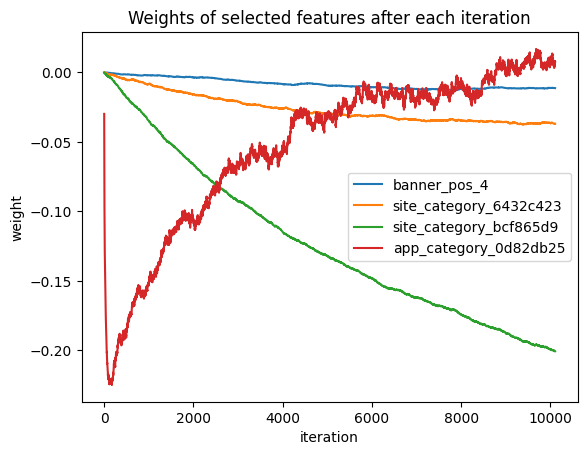

In [12]:
indices_weights = [10,20,30,40]
weight_names = list(feature_names[i] for i in indices_weights)
LSGD.plot_weights(
    indices_weights=indices_weights,
    weight_names=weight_names)

We can also visualize how ``log_likelihood`` changes in during the learning process:

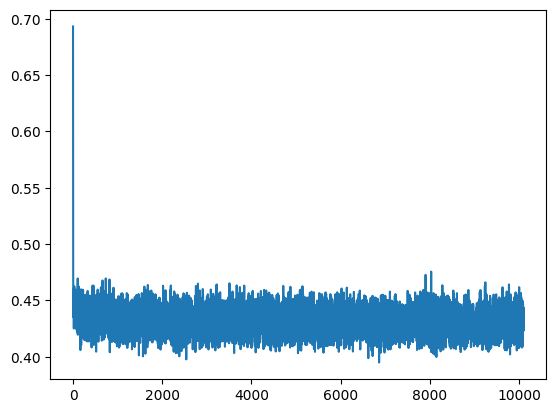

In [13]:
plt.plot(LSGD.log_likelihood)

# SGD With `sklearn`

To investigate how the implementation of SGD in `effCTR` compares to `SGDClassifier` from `sklearn`, the code snippet below evaluates the training time and performance on test data of `SGDClassifier`.

In [15]:
start_time = time.time()
LSGD = SGDClassifier(max_iter=1, loss='log_loss', alpha=0, fit_intercept=False,
                     learning_rate='constant', eta0=0.0001)
LSGD.fit(X_train, y_train.A.reshape(-1))
train_time = time.time() - start_time

# log_loss on train set
preds_logistic_train = LSGD.predict_proba(X_train)
log_loss_logistic_train = log_loss(preds_logistic_train[:, 1], y_train)

# log_loss on train set
preds_logistic_test = LSGD.predict_proba(X_test)
log_loss_logistic_test = log_loss(preds_logistic_test[:, 1], y_test)
print(f'This is training time: {train_time}')
print(f'This is log_loss obtained on a train set: {log_loss_logistic_train}')
print(f'This is log_loss obtained on a test set: {log_loss_logistic_test}')

/Users/kacper/all_venv/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:704: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


This is training time: 379.90499472618103
This is log_loss obtained on a train set: 0.43102464021571807
This is log_loss obtained on a test set: 0.43089965100667554


We can see that using `SGDClassifier` in its basic form results in a similar log_loss to `effCTR`, but the training is 50-60x slower on the dataset that consists of ~32mln observations.